<a href="https://colab.research.google.com/github/ranjithsrajan/PyLab/blob/main/M4_AST_07_CNN_1_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Data Science and Machine Learning
## A program by IITM and TalentSprint
### Assignment 07: Convolutional Neural Networks

### Setup Steps:

In [3]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython

ipython = get_ipython()

notebook= "M4_AST_07_CNN_1_C" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")

    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword(),"batch":"IITM-PG-ADSML-07"}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:
        print(r["err"])
        return None
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer() and getComplexity() and getAdditional() and getConcepts() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional,
              "concepts" : Concepts, "record_id" : submission_id,
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support,"batch":"IITM-PG-ADSML-07"}
      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:
        print(r["err"])
        return None
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://learn-iitm.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id


def getAdditional():
  try:
    if not Additional:
      raise NameError
    else:
      return Additional
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None

def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None


# def getWalkthrough():
#   try:
#     if not Walkthrough:
#       raise NameError
#     else:
#       return Walkthrough
#   except NameError:
#     print ("Please answer Walkthrough Question")
#     return None

def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None


def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer():
  try:
    if not Answer:
      raise NameError
    else:
      return Answer
  except NameError:
    print ("Please answer Question")
    return None


def getId():
  try:
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


## Learning Objectives

At the end of the experiment, you will be able to

* understand the concept of convolutional neural networks.
* implement a simple convolution operation from scratch.
* train convolution neural network in `Keras`.
* understand applications of CNN.
  * Classification task.

### What is Convolution?

The 2D convolution operation is a simple operation that can defined by the following steps:
1. Start with a kernel, which is simply a small matrix of weights.
2. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel.

A visualization is available below.

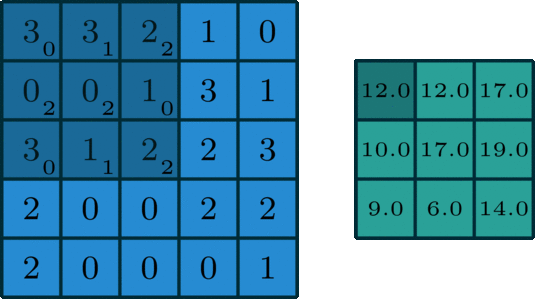

Before we dive deep into how convolutional neural networks work, we would like to show the convolution operation from scratch.

### Import required packages

In [4]:
# Importing standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from glob import glob
import cv2
import random

# Importing Tensorflow and keras
import tensorflow as tf
from tensorflow import keras

# Importing different sklearn stuff
from sklearn import datasets


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D

from sklearn.metrics import accuracy_score

# Import the mnist dataset
from keras.datasets import mnist

# Train-test split
from sklearn.model_selection import train_test_split

import math

### Convlolution from scratch

Let us see how convolution operation affects an image. The below code snippets can be used to convolve a 2D grayscale image with any arbitrary square filters. We show the results with a very simple filter called the `Sobel Filter`.  The sobel filter has a very simple kernel of 1's and 0's which when convolved with any image, captures the edges of the image.

In [6]:
# A function needed to pad the image
def pad(I, winsize):
    p = int(math.floor(winsize/2))
    I = np.pad(I, ((p,p),(p,p)), 'constant')
    return I, p

In [7]:
# Multiplying the kernel with a particular region of the image
# This multiplication is for a particuklar window
def maskmult(I, mask):
    if (I.shape[0]!=mask.shape[0] and I.shape[1]!=mask.shape[1]):
        print ("SHAPE ERROR!")
        exit()
    s = 0
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            temp_s = I[i][j] * mask[i][j]
            s = s + temp_s

    return s

In [8]:
# Defining the convolutionon operation
def conv2d(image, mask, padding='SAME', strides=[1,1]):
    mask = np.asarray(mask)
    orgheight = image.shape[0]
    orgwidth = image.shape[1]
    winsize = mask.shape[0]
    image, p = pad(image, winsize)
    height = image.shape[0]
    width = image.shape[1]
    op_w = int((orgwidth-mask.shape[1]+2*p)/strides[1]) + 1
    op_h = int((orgheight-mask.shape[0]+2*p)/strides[0]) + 1
    thIm = np.zeros([op_h, op_w])
    rcnt = 0
    i=0
    cnt=0
    while (i<height):
        ccnt = 0
        j=0
        while (j<width):
            if i+winsize <= height and j+winsize <= width:
                rs=i
                re = i+winsize
                cs = j
                ce = j+winsize
                cropimage = image[rs:re, cs:ce]
                thIm[rcnt][ccnt] = maskmult(cropimage, mask)
            ccnt = ccnt + 1
            j=j+strides[1]
        rcnt = rcnt+1
        i=i+strides[0]
    return thIm

Let us now download an image and see the effect.

In [9]:
#@title Download the image
!wget "https://media.istockphoto.com/photos/white-passenger-bus-picture-id135327019?k=20&m=135327019&s=612x612&w=0&h=YJneXYFReSVuKSIFOy5wGIygeLeb1UquX4BWLk-MluI=" -O image.jpg

--2026-01-10 06:09:23--  https://media.istockphoto.com/photos/white-passenger-bus-picture-id135327019?k=20&m=135327019&s=612x612&w=0&h=YJneXYFReSVuKSIFOy5wGIygeLeb1UquX4BWLk-MluI=
Resolving media.istockphoto.com (media.istockphoto.com)... 143.204.160.107, 143.204.160.125, 143.204.160.91, ...
Connecting to media.istockphoto.com (media.istockphoto.com)|143.204.160.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29987 (29K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  29.28K  --.-KB/s    in 0s      

2026-01-10 06:09:23 (60.2 MB/s) - ‘image.jpg’ saved [29987/29987]



We now use the downloaded image and check the result of convolving it with the sobel filter.

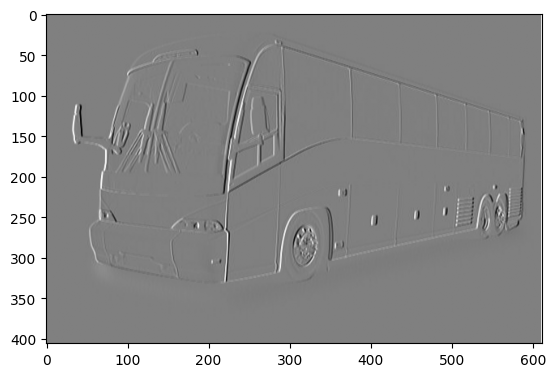

In [10]:
# Reading the image
I = cv2.imread("image.jpg", 0)

# Defining the sobel mask
# [[1, 0, -1]
#  [1, 0, -1]
#  [1, 0, -1]]
mask = [[1, 0, -1], [1, 0, -1], [1, 0, -1]]
#mask= [[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]]
mask = np.asarray(mask)

I1 = conv2d(I.copy(), mask, strides=[1,1])

# Plotting the image
plt.imshow(I1, cmap="gray")
plt.show()

As we can see, convolution can be used to capture different features of an image. Here, we used a known kernel that had the values hard coded in it! However, what if, these values were randomly initialized and then learnt by the network similar to how weights are learned in an MLP? That is exactly what happens in a CNN, where the kernels are learned by the network automatically with an aim to minimize the loss.

### Why MLP is not ideal for images?
In the MNIST dataset, each image in MNIST is $28 \times 28 \times 1$(black & white image contains only 1 channel). Total number of neurons in input layer will $28 \times 28 = 784$, this can be manageable. What if the size of image is $1000 \times 1000$ which means you need $10^6$ neurons in input layer. This is a huge number of neurons are required for operation. It is computationally ineffective right. So here comes Convolutional Neural Network or CNN. In simple word what CNN does is, it extract the feature of image and convert it into lower dimension without loosing its characteristics.

### Motivation for Using Convolutional Neural Network

The human brain processes information to  see an image. Each neuron works in its own receptive field and is connected to other neurons in a way that they cover the entire visual field. Just as each neuron responds to stimuli only in the restricted region of the visual field called the receptive field in the biological vision system, each neuron in a CNN processes data only in its receptive field as well. The layers are arranged in such a way so that they detect simpler patterns first (lines, curves, etc.) and more complex patterns (faces, objects, etc.) further along.

This is mainly achieved by the above mentioned convolution operation. In a CNN, the convolutional filters are initialized randomly, just like weights and biases are initialized randomly in an MLP. Not only one, but multiple filters are used in a single convolution layer. CNNs work by applying filters to your input data. What makes them so special is that CNNs are able to tune the filters as training happens. That way the results are fine-tuned in real time, even when you have huge data sets, like with images.

Since the filters can be updated to train the CNN better, this removes the need for hand-created filters. That gives us more flexibility in the number of filters we can apply to a data set and the relevance of those filters. Using this algorithm, we can work on more sophisticated problems like face recognition.

# General Structure of a CNN

Neurons in the first convolutional layer are not connected to every single pixel in the input image (like they were in the layers of DNN), but only to pixels in their receptive fields as shown in the figure below. In turn, each neuron in the second convolutional layer is connected only to neurons located within a receptive field in the first layer.

This architecture allows the network to concentrate on small low-level features in the first hidden layer, then assemble them into larger higher-level features in the next hidden layer, and so on.
<center>
<img src="https://cdn.iisc.talentsprint.com/CDS/Images/conv_layers_multiple_fmap.png" width=600px/>
</center>
$\hspace{6cm} \text {Convolutional layers with multiple feature maps, and images with three color channels}$
<br><br>

A neuron’s weights can be represented as a small image with the size of the receptive field. This is termed as **filter**. And, a layer full of neurons using the same filter outputs a **feature map**, which highlights the areas in an image that activate the filter the most.

A convolutional layer has multiple filters and outputs one feature map per filter, also:

* it has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters (i.e., the same weights and bias term).

* neurons in different feature maps use different parameters.

* a neuron’s receptive field extends across all the previous layers’ feature maps i.e, its shape will be $f_h$ x $f_w$ x depth of previous layer, where $f_h$ and $f_w$ are the height and width of the receptive field.

In short, a convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.

We first describe the generic structure of a CNN network. Please note that, this is only an example and the layers people use are ever changing!

**Input Layer**

Input layer in CNN should contain image data. Image data is represented by three dimensional matrix as we saw earlier. The input will thus have a shape of $H \times W\times C$, where H is the height, W is the width and C is the number of channels.

**Convolution Layer**

Layers which has learnable kernels which performs convolution on the the given input to such layers.

**Pooling Layer**

Pooling layer is used to reduce the spatial volume of input image after convolution. It is used between two convolution layers to reduce the dimension of the image.  In the below example, we have applied max pooling in single depth slice with Stride of 2. You can observe the 4 x 4 dimension input is reduce to 2 x 2 dimension.
There is no parameter in pooling layer but it has two hyperparameters — Filter(F) and Stride(S).
In general, if we have input dimension W1 x H1 x D1, then

W2 = (W1−F)/S+1

H2 = (H1−F)/S+1

D2 = D1

Where W2, H2 and D2 are the width, height and depth of output.




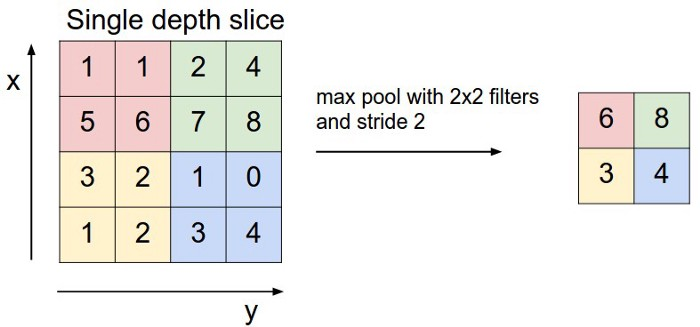

**Fully Connected Layers**

These are layers that we used in a multi layer perceptron. These layers are often used at the end of a CNN. The 2D output from the last convolution layer is flattened and fed to one or more FC layers before feeding it to the softmax classifier. These are not needed in several problems, but is quite popular in classification ones!

Let us also talk about strides and padding in a neural network and see why is it required.

**Padding and Strides in a Convolutional Layer**

Stride denotes how many steps we are moving in each steps in convolution.By default it is one.



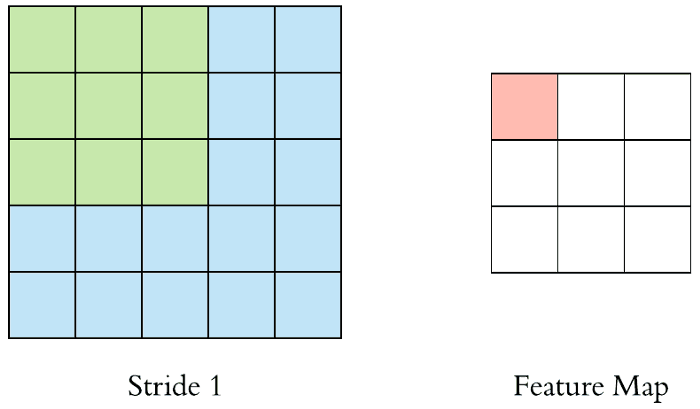

We can observe that the size of output is smaller that input. To maintain the dimension of output as in input , we use padding. Padding is a process of adding zeros to the input matrix symmetrically. In the following example,the extra grey blocks denote the padding. It is used to make the dimension of output same as input.

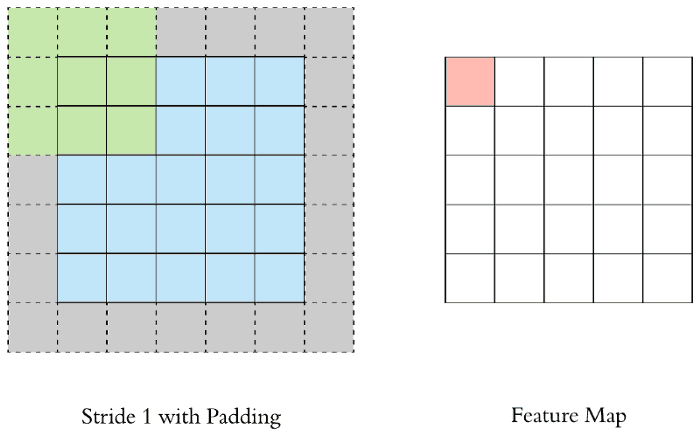

**Output size relationship with input size, filter size, padding and strides**

The relationship between input image size, padding and filter shape with the output image size from a convolution layer is given by a simple equation.

Given, an image of $N \times N$ dimension, a filter of $F \times F$, padding of $(p, p)$ the output image size will be -

$(N+2p-F+1) \times (N+2p-F+1)$

With strides $s$, we will have the output size as -

$[ {(N + 2𝑝 − F + 1) / 𝑠} + 1] ∗ [ {(N + 2𝑝 − F + 1) / 𝑠} + 1]$

In `keras`, we have 2 options for padding. They are `same` and `valid`.

When stride is 1, we can think of the following distinction:

"SAME": output size is the same as input size. This requires the filter window to slip outside input map, hence the need to pad.

"VALID": Filter window stays at valid position inside input map, so output size shrinks by filter_size - 1. No padding occurs.

**Number of filters used in a layer**

We also don't convolve an input with a single filter as mentioned previously. Every layer has multiple number of filters. If there are $M$ number of filters present in a particular layer, the output from the layer will have $M$ channels.


**Verifying the relationship using Keras layers**

Before moving on to real training, let us look at the layer definations and also verify the size relationship we just discussed. It is very important, since a lot of architecture design goes into understanding the input and expected sizes of the output.

In [11]:
# Checking how strides, padding and filter size affects the shape of input of NxN
N = 28
model = Sequential()

# (Number of convolution filters present, filter size, input_size, padding=automatically calculates to keep the input size same, strides)
model.add(Conv2D(32, (3, 3), input_shape=(N, N, 1), padding='SAME', strides=1))
print ("---------------------------------------------------------------------------------------------------------")
model.summary()

model = Sequential()

# Lets use 0 padding
# (Number of convolution filters present, filter size, input_size, padding=0, strides)
model.add(Conv2D(32, (3, 3), input_shape=(N, N, 1), padding='VALID', strides=1))

model.summary()
print ("---------------------------------------------------------------------------------------------------------")

model = Sequential()

# Lets use padding and strides = 2
# (Number of convolution filters present, filter size, input_size, padding, strides)
model.add(Conv2D(32, (3, 3), input_shape=(N, N, 1), padding='SAME', strides=2))

model.summary()

---------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

---------------------------------------------------------------------------------------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

As we can see, our formula holds true for the CNN layers and we get expected shapes as output. Let us now train a simple CNN based neural network on the MNIST dataset. The MNIST dataset is downloaded and displayed below.

### MNIST Dataset

MNIST dataset consists of over $60,000$ train images and $10,000$ test images from 10 digit classes ($0 - 9$) and is available in several libraries. We load the data below and will use it for training multiple linear classifiers.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
-----------Stats-----------
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
-----------Plots-----------
Label of the below image:  0


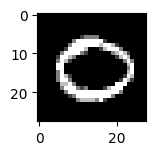

Label of the below image:  3


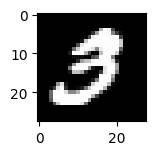

In [12]:
# Loading the MNIST dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print ("-----------Stats-----------")


# Printing the shapes of the data for checking the numbers in train and test split.
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

print ("-----------Plots-----------")

# Plotting two images randomly and also printing their labels
for i in range(2):
  j = np.random.randint(0, 60000)
  plt.subplot(330 + 1 + i)
  plt.imshow(train_X[j], cmap=plt.get_cmap('gray'))
  print ("Label of the below image: ", train_y[j])
  plt.show()

We convert the labels into one-hot vector using a small piece of code.

In [13]:
# Defining the function to change class numbers to one-hot vectors
# Number of classes is defined
# A batch of data is sent instead of one at a time to this function
# all_y is of the shape (N,). Here N is the number of samples which is 10,000 for test and 60,000 for train
def class2onehot(all_y, num_classes=10):
  all_one_hot = []
  for one_y in all_y:
    one_hot = np.zeros(num_classes)
    one_hot[one_y] = 1
    all_one_hot.append(one_hot)
  return np.array(all_one_hot)

Lets change the label representation for both train and test data.

In [14]:
# Making class labels into one hot vectors
train_y_onehot = class2onehot(train_y)
test_y_onehot = class2onehot(test_y)

### Defining the Convolutional Neural Network


As mentioned earlier, the CNN network will have the a bunch of CNN layers with ReLU activation. We will also have maxpooling layers in between. Finally the network will have dense layers near the end.



In [15]:
# Defining the model for MNIST.
model = Sequential()

# Convlution layer followed by max pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

# Flattening to make the input an 1D vector
model.add(Flatten())

# Adding the dense layers
model.add(Dense(64, activation='relu'))

# Adding the final classification layer (10 classes)
model.add(Dense(10, activation='softmax'))

We have defined our model above. Let us check out the summary of this model and then compile it and train.

In [16]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_X, train_y_onehot, epochs=1)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 54s 27ms/step - accuracy: 0.8751 - loss: 0.7535


We train the model for a single epoch and test its performance on the test set.

In [18]:
test_loss, test_acc = model.evaluate(test_X,  test_y_onehot, verbose=2)
print ("The test-time accuracy on the MNIST dataset is: ", test_acc)

313/313 - 3s - 10ms/step - accuracy: 0.9723 - loss: 0.0856
The test-time accuracy on the MNIST dataset is:  0.9722999930381775


We get a high test set accuracy for MNIST dataset.

Now let us check how CNN can be used for solving other real world classification problems. We can test how the classifier works when trained on a dataset with COVID affected lungs. Can our model beat the accuracy achieved by a MLP on the dataset (MLP achieved 85\% of accuracy)

In [19]:
# @title Covid-19 Dataset
!wget https://cdn.iisc.talentsprint.com/ADSMI/Datasets/covid_dataset.zip

--2026-01-10 06:58:54--  https://cdn.iisc.talentsprint.com/ADSMI/Datasets/covid_dataset.zip
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 816029038 (778M) [application/zip]
Saving to: ‘covid_dataset.zip’

covid_dataset.zip   100%[===================>] 778.23M  12.4MB/s    in 77s     

2026-01-10 07:00:12 (10.1 MB/s) - ‘covid_dataset.zip’ saved [816029038/816029038]



Unzipping the dataset

In [20]:
%%capture
!unzip covid_dataset.zip

Let us first check the folder structure of the dataset and determine the things we are going to use.

In [21]:
!ls COVID-19_Radiography_Dataset/

 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


As we can see, the folder `COVID-19_Radiography_Dataset/COVID` contains images of covid affected lungs while `COVID-19_Radiography_Dataset/Normal` contains images from normal lungs. Our main goal is to classify between these two types. So let us create the dataset!

In [22]:
# Storing filenames of all the images from both the folders
all_covid_images = glob("COVID-19_Radiography_Dataset/COVID/images/*.png")
all_normal_images = glob("COVID-19_Radiography_Dataset/Normal/images/*.png")

print ("Number of COVID images: ", len(all_covid_images))
print ("Number of normal images: ", len(all_normal_images))

# To remove class imbalance we select less number of normal images
# There are other ways to remove class imbalance too. We do a random selection here
all_normal_images = random.choices(all_normal_images, k=len(all_covid_images))

print ("Number of normal images that were selected randomly: ", len(all_normal_images))

# Defining the labels of the classes
COVID_LABEL = 0
NORMAL_LABEL = 1

Number of COVID images:  3616
Number of normal images:  10192
Number of normal images that were selected randomly:  3616


Lets randomly plot some samples from the dataset

Sample COVID image


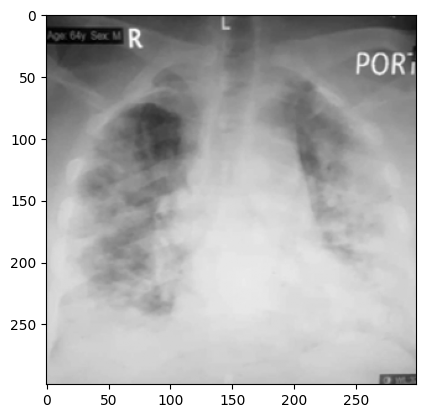

Sample Normal image


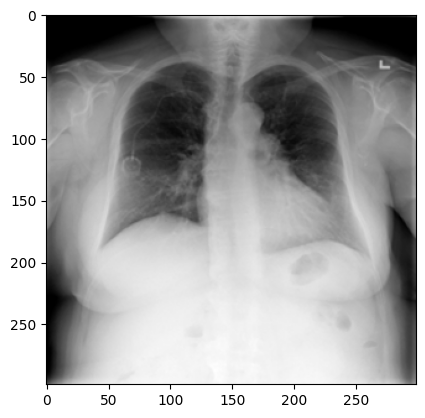

In [23]:
# Randomly plotting one sample each from both the classes!
random_covid_image_filename = random.choice(all_covid_images)
random_covid_image = cv2.imread(random_covid_image_filename, 0)
plt.imshow(random_covid_image, cmap=plt.get_cmap('gray'))
print ("Sample COVID image")
plt.show()

random_normal_image_filename = random.choice(all_normal_images)
random_normal_image = cv2.imread(random_normal_image_filename, 0)
plt.imshow(random_normal_image, cmap=plt.get_cmap('gray'))
print ("Sample Normal image")
plt.show()

We will read the images and store them in numpy arrays. We will also resize the images to 28x28 like MNIST. This is not ideal and done for demo purposes only! You can change the size of the images in the code. Also don't forget to change the size of the input layer in that case!

In [24]:
# List to get all the images and the corresponding labels.
all_images_labels = []

# Fixing image size
IMAGE_SIZE = 100

# Reading all the covid images
for one_image_name in all_covid_images:
  # one_image_name contains the filename of the image
  # The parameter 0 ensures its loaded in grayscale!
  one_image = cv2.imread(one_image_name, 0)
  one_image = cv2.resize(one_image, (IMAGE_SIZE, IMAGE_SIZE))

  all_images_labels.append([one_image, COVID_LABEL])


# Reading all the normal images
for one_image_name in all_normal_images:
  # one_image_name contains the filename of the image
  # The parameter 0 ensures its loaded in grayscale!
  one_image = cv2.imread(one_image_name, 0)
  one_image = cv2.resize(one_image, (IMAGE_SIZE, IMAGE_SIZE))

  all_images_labels.append([one_image, NORMAL_LABEL])

# We shuffle the list to make sure the dataset does not introduce undue bias
random.shuffle(all_images_labels)

# We now separate out the X and y, where X are the image inputs and y are the GT labels!
X = []
y = []
for one_image_label in all_images_labels:
  X.append(one_image_label[0])
  y.append(one_image_label[1])


X = np.array(X)
y = np.array(y)

print ("The shape of the input: ", X.shape)
print ("The shape of the ground-truth: ", y.shape)

The shape of the input:  (7232, 100, 100)
The shape of the ground-truth:  (7232,)


Therefore, we have reshaped our input and ground-truth similar to MNIST. We now, divide the dataset into train and test sets. We will be using 90% of the dataset for training and 10% for testing!

In [25]:
# Dividing the dataset into train and test sets!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

Let us now train the model and check the results! We use a slightly deeper model in this case and use `keras` for training.

In [26]:
# Defining the model for the new dataset.
model = Sequential()

# Convlution layer followed by max pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

# Flattening to make the input an 1D vector
model.add(Flatten())

# Adding the dense layers
model.add(Dense(64, activation='relu'))

# Adding the final classification layer (10 classes)
model.add(Dense(1, activation='sigmoid'))

Compiling the above model with binary-crossentropy loss. Remember we have only 2 classes in this case. So a single value can determine the class. Anything below 0.5 belongs to class 0 and vice-versa.

In [27]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Let us fit the data to our model and measure the accuracy!

In [28]:
# Training loop.
# epochs is the number of epochs the model needs to run
# batch_size of a single run

model.fit(X_train, y_train, epochs=15, batch_size=100)

Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.6218 - loss: 18.4478
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.8526 - loss: 0.3448
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8936 - loss: 0.2726
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9299 - loss: 0.1841
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9479 - loss: 0.1321
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9624 - loss: 0.0961
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9692 - loss: 0.0897
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9843 - loss: 0.0487
Epoch 9/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9889 - loss: 0.0375
Epoch 10/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9881 - loss: 0.0378
Epoch 11/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9776 - loss: 0.0586
Epoch 12/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9

We trained our model for 100 epochs and got  training accuracy of close to 97% (compared to 88.95% of MLP!)  Let us now test our model on the test set and get the test accuracy.

In [29]:
_, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy using CNN: %.2f' % (accuracy))

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9085 - loss: 0.3290
Test Accuracy using CNN: 0.93


## Please answer the questions below to complete the experiment:




In [30]:
# @title In the context of CNNs, what does the term "stride" refer to? { run: "auto", form-width: "500px", display-mode: "form" }
Answer = "The step size with which the convolutional filter moves across the input" #@param ["","The number of layers in the network", "The number of filters in a convolutional layer", "The step size with which the convolutional filter moves across the input",""]

In [31]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging for me" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]

In [32]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "NA" #@param {type:"string"}

In [33]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]

In [34]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]

In [35]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]

In [36]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 2081
Date of submission:  10 Jan 2026
Time of submission:  13:03:55
View your submissions: https://learn-iitm.talentsprint.com/notebook_submissions
